# Datasets

In [1]:
from datasets import get_dataset_config_names

xtreme_subsets = get_dataset_config_names('xtreme')

In [2]:
print(f'{len(xtreme_subsets)} configurations available')

183 configurations available


In [3]:
panx_subsets = [s for s in xtreme_subsets if s.startswith('PAN')]
print(f'{len(panx_subsets)} sub-datasets available')
print(panx_subsets[:5])

40 sub-datasets available
['PAN-X.af', 'PAN-X.ar', 'PAN-X.bg', 'PAN-X.bn', 'PAN-X.de']


In [4]:
from datasets import load_dataset

load_dataset('xtreme', 'PAN-X.de')

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 20000
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
})

Create a realistic Swiss corpus by oversampling German, French while undersampling Italian and English

In [6]:
from collections import defaultdict
from datasets import DatasetDict

langs = ['de', 'fr', 'it', 'en']
fracs = [0.629, 0.229, 0.084, 0.059]

panx_ch = defaultdict(DatasetDict)

for lang, frac in zip(langs, fracs):
    ds = load_dataset('xtreme', name=f'PAN-X.{lang}')
    for split in ds:
        n = int(frac * ds[split].num_rows)
        panx_ch[lang][split] = ds[split].shuffle(seed=0).select(range(n))

In [7]:
# display how many samples by language
import pandas as pd

pd.DataFrame({lang: [panx_ch[lang]['train'].num_rows] for lang in langs}, index=['Number of samples'])

,de,fr,it,en
Number of samples,12580,4580,1680,1180


Zero-shot cross-lingual transfer.

In [8]:
pd.DataFrame(panx_ch['de']['train'][0])

,tokens,ner_tags,langs
0,2.000,0,de
1,Einwohnern,0,de
2,an,0,de
3,der,0,de
4,Danziger,5,de
5,Bucht,6,de
6,in,0,de
7,der,0,de
8,polnischen,5,de
9,Woiwodschaft,5,de


In [9]:
tags = panx_ch['de']['train'].features['ner_tags'].feature
print(tags)

ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None)


In [10]:
def create_tag_names(batch):
    return {'ner_tags_str': [tags.int2str(idx) for idx in batch['ner_tags']]}
panx_de = panx_ch['de'].map(create_tag_names)

In [11]:
de_example = panx_de['train'][0]
pd.DataFrame(de_example['tokens'], de_example['ner_tags_str'])

,0
O,2.000
O,Einwohnern
O,an
O,der
B-LOC,Danziger
I-LOC,Bucht
O,in
O,der
B-LOC,polnischen
B-LOC,Woiwodschaft


In [12]:
from collections import Counter
split2freqs = defaultdict(Counter)
for split, dataset in panx_de.items():
 for row in dataset["ner_tags_str"]:
    for tag in row:
        if tag.startswith("B"):
            tag_type = tag.split("-")[1]
            split2freqs[split][tag_type] += 1
pd.DataFrame.from_dict(split2freqs, orient="index")


,LOC,ORG,PER
train,6186,5366,5810
validation,3172,2683,2893
test,3180,2573,3071


# Tokenization

In [13]:
# Compare word-piece and sentence-piece tokenizers

from transformers import AutoTokenizer
bert_tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
xlmr_tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")

text = 'Jack Sparrow loves New York!'
bert_tokens = bert_tokenizer(text).tokens()
xlmr_tokens = xlmr_tokenizer(text).tokens()

c:\Users\lived\miniconda3\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [14]:
pd.DataFrame([bert_tokens, xlmr_tokens], index=["BERT", "XLM-R"])

,0,1,2,3,4,5,6,7,8,9
BERT,[CLS],Jack,Spa,##rrow,loves,New,York,!,[SEP],None
XLM-R,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>


In [15]:
"".join(xlmr_tokens).replace(u"\u2581", " ")

'<s> Jack Sparrow loves New York!</s>'

# Transformers Anatomy

In [16]:
import torch.nn as nn
from transformers import XLMRobertaConfig
from transformers.modeling_outputs import TokenClassifierOutput
from transformers.models.roberta.modeling_roberta import RobertaModel
from transformers.models.roberta.modeling_roberta import RobertaPreTrainedModel

class XLMRobertaForTokenClassification(RobertaPreTrainedModel):
    config_class = XLMRobertaConfig
    
    def __init__(self, config):
        super().__init__(config)
        
        self.num_labels = config.num_labels
        self.roberta = RobertaModel(config, add_pooling_layer=False)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        
        self.init_weights()
        
    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, labels=None):
        outputs = self.roberta(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        sequence_output = outputs[0]
        sequence_output = self.dropout(sequence_output)
        logits = self.classifier(sequence_output)
        
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        
        return TokenClassifierOutput(loss=loss, logits=logits, hidden_states=outputs.hidden_states, attentions=outputs.attentions)


In [17]:
from transformers import AutoConfig

index2tag = { idx: tag for idx, tag in enumerate(tags.names)}
tag2index = { tag: idx for idx, tag in enumerate(tags.names)}

xlmr_model_name = 'xlm-roberta-base'
xlmr_config = AutoConfig.from_pretrained(
    xlmr_model_name,
    num_labels = tags.num_classes,
    id2label=index2tag,
    label2id=tag2index
)

In [18]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
xlmr_model = XLMRobertaForTokenClassification.from_pretrained(
    xlmr_model_name,
    config=xlmr_config
).to(device)

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
input_ids = xlmr_tokenizer.encode(text, return_tensors='pt')
pd.DataFrame([xlmr_tokens, input_ids[0].numpy()], index=["Tokens", "Input IDs"])

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Input IDs,0,21763,37456,15555,5161,7,2356,5753,38,2


In [20]:
outputs = xlmr_model(input_ids.to(device)).logits
print(outputs)
print(outputs.shape)

tensor([[[ 0.4889,  0.3391,  0.1189,  0.1818,  0.2465, -0.0391, -0.2948],
         [ 0.6397,  0.0447,  0.1805, -0.1753,  0.1437,  0.3044, -0.4150],
         [ 0.7030,  0.0191,  0.2443, -0.1507,  0.2964,  0.2304, -0.3753],
         [ 0.6094,  0.0249,  0.1897, -0.1158,  0.0819,  0.3684, -0.4182],
         [ 0.5751,  0.0813,  0.2204, -0.1810,  0.0405,  0.3394, -0.5079],
         [ 0.5575,  0.0700,  0.1887, -0.1384,  0.1458,  0.2392, -0.4292],
         [ 0.6576, -0.0441,  0.2137, -0.1530,  0.2376,  0.2316, -0.5055],
         [ 0.6228, -0.0827,  0.1915, -0.1522,  0.0840,  0.3201, -0.5576],
         [ 0.6444,  0.1047,  0.2928, -0.1850,  0.2404,  0.2792, -0.4078],
         [ 0.4075,  0.3339,  0.1767,  0.2288,  0.3242, -0.1027, -0.3034]]],
       device='cuda:0', grad_fn=<ViewBackward0>)
torch.Size([1, 10, 7])


c:\Users\lived\miniconda3\Lib\site-packages\transformers\models\roberta\modeling_roberta.py:370: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


In [21]:
predictions = torch.argmax(outputs, -1)
print(predictions)
print(predictions.shape)

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], device='cuda:0')
torch.Size([1, 10])


In [22]:
preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
pd.DataFrame([xlmr_tokens, preds], index=["Tokens", "Tags"])

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Tags,O,O,O,O,O,O,O,O,O,O


In [23]:
def tag_text(text, tags, model, tokenizer):
    # Get tokens with special characters
    tokens = tokenizer(text).tokens()
    # Encode the sequence into IDs
    input_ids = xlmr_tokenizer(text, return_tensors="pt").input_ids.to(device)
    # Get predictions as distribution over 7 possible classes
    outputs = model(input_ids)[0]
    # Take argmax to get most likely class per token
    predictions = torch.argmax(outputs, dim=2)
    # Convert to DataFrame
    preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
    return pd.DataFrame([tokens, preds], index=["Tokens", "Tags"])

In [24]:
tag_text('Kamala Harris is the worst presidental candidate of all time!', tags, xlmr_model, xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Tokens,<s>,▁Kamal,a,▁Harris,▁is,▁the,▁worst,▁president,al,▁candidat,e,▁of,▁all,▁time,!,</s>
Tags,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O


# Tokenize dataset

In [25]:
words, labels = de_example['tokens'], de_example['ner_tags']

pd.DataFrame([words, labels], index=["Words", "Labels"])

,0,1,2,3,4,5,6,7,8,9,10,11
Words,2.000,Einwohnern,an,der,Danziger,Bucht,in,der,polnischen,Woiwodschaft,Pommern,.
Labels,0,0,0,0,5,6,0,0,5,5,6,0


In [26]:
tokenized_input = xlmr_tokenizer(de_example["tokens"], is_split_into_words=True)
print(tokenized_input.input_ids)

[0, 70101, 176581, 19, 142, 122, 2290, 708, 1505, 18363, 18, 23, 122, 127474, 15439, 13787, 14, 15263, 18917, 663, 6947, 19, 6, 5, 2]


In [27]:
tokens = xlmr_tokenizer.convert_ids_to_tokens(tokenized_input.input_ids)
pd.DataFrame([tokens], index=["Tokens"])

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>


In [28]:
word_ids = tokenized_input.word_ids()
pd.DataFrame([tokens, word_ids], index=["Tokens", "Word IDs"])

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
Word IDs,None,0,1,1,2,3,4,4,4,5,...,9,9,9,9,10,10,10,11,11,None


Assign -100 to IGN Labels.

In [29]:
previous_word_idx = None
label_ids = []
for word_idx in word_ids:
    if word_idx is None or word_idx == previous_word_idx:
        label_ids.append(-100)
    elif word_idx != previous_word_idx:
        label_ids.append(labels[word_idx])
    previous_word_idx = word_idx
labels = [index2tag[l] if l != -100 else "IGN" for l in label_ids]
index = ["Tokens", "Word IDs", "Label IDs", "Labels"]
pd.DataFrame([tokens, word_ids, label_ids, labels], index=index)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
Word IDs,None,0,1,1,2,3,4,4,4,5,...,9,9,9,9,10,10,10,11,11,None
Label IDs,-100,0,0,-100,0,0,5,-100,-100,6,...,5,-100,-100,-100,6,-100,-100,0,-100,-100
Labels,IGN,O,O,IGN,O,O,B-LOC,IGN,IGN,I-LOC,...,B-LOC,IGN,IGN,IGN,I-LOC,IGN,IGN,O,IGN,IGN


In [30]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = xlmr_tokenizer(
        examples['tokens'],
        truncation=True,
        is_split_into_words=True,
    )
    labels = []
    for idx, label in enumerate(examples['ner_tags']):
        word_ids = tokenized_inputs.word_ids(batch_index=idx)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None or word_idx == previous_word_idx:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [31]:
def encode_panx_dataset(corpus):
    return corpus.map(tokenize_and_align_labels, batched=True, remove_columns=['langs', 'ner_tags', 'tokens'])

In [32]:
panx_de_encoded = encode_panx_dataset(panx_de)

In [33]:
pd.DataFrame(panx_de_encoded['train'])

,ner_tags_str,input_ids,attention_mask,labels
0,"[O, O, O, O, B-LOC, I-LOC, O, O, B-LOC, B-LOC,...","[0, 70101, 176581, 19, 142, 122, 2290, 708, 15...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-100, 0, 0, -100, 0, 0, 5, -100, -100, 6, -10..."
1,"[O, O, O, B-ORG, O, O, O, B-ORG, I-ORG, O, O]","[0, 727, 8644, 39119, 23706, 20101, 24, 9703, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-100, 0, 0, 0, 3, -100, 0, -100, -100, 0, 0, ..."
2,"[O, O, O, O, B-PER, I-PER, O, B-PER, I-PER, O,...","[0, 230978, 33, 542, 12389, 47323, 1225, 96513...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-100, 0, -100, 0, 0, -100, 0, 1, 2, -100, -10..."
3,"[O, O, B-ORG, I-ORG, O, O]","[0, 242, 5106, 46231, 13, 20130, 4432, 5106, 2...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[-100, 0, 0, 3, -100, 4, -100, 0, 0, -100]"
4,"[O, B-PER, I-PER, I-PER, I-PER]","[0, 1392, 6765, 821, 5, 436, 5, 3253, 1728, 2]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[-100, 0, 1, 2, -100, 2, -100, 2, -100, -100]"
...,...,...,...,...
12575,"[B-PER, I-PER, O, O, O, O, O, O]","[0, 94069, 160794, 6, 4, 93563, 2235, 122, 479...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[-100, 1, 2, 0, -100, 0, 0, 0, 0, -100, -100, ..."
12576,"[O, O, O, O, O, O, O, O, O, O, O, B-ORG, I-ORG...","[0, 2991, 7418, 98555, 72, 5445, 1329, 33415, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-100, 0, 0, 0, 0, -100, 0, 0, 0, 0, 0, 0, 0, ..."
12577,"[O, B-LOC, O, O, O, O, O, O, O, O, O, O, O, O, O]","[0, 1310, 104998, 56, 491, 714, 219160, 19, 41...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-100, 0, 5, -100, 0, 0, 0, -100, 0, 0, -100, ..."
12578,"[O, B-LOC, O, B-LOC, O, O, O, O, O, O, O]","[0, 360, 7145, 11, 18339, 165, 128267, 402, 49...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-100, 0, 5, -100, -100, 0, 5, -100, 0, -100, ..."


# Metrics

In [34]:
from seqeval.metrics import classification_report

y_true = [
    ["O", "O", "O", "B-MISC", "I-MISC", "I-MISC", "O"],
    ["B-PER", "I-PER", "O"]
]
y_pred = [
    ["O", "O", "B-MISC", "I-MISC", "I-MISC", "I-MISC", "O"],
    ["B-PER", "I-PER", "O"]
]

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

        MISC       0.00      0.00      0.00         1
         PER       1.00      1.00      1.00         1

   micro avg       0.50      0.50      0.50         2
   macro avg       0.50      0.50      0.50         2
weighted avg       0.50      0.50      0.50         2



Define function to convert output to a list that `seqeval` can process.

In [35]:
import numpy as np
def align_predictions(predictions, label_ids):
    preds = np.argmax(predictions, axis=2)
    batch_size, seq_len = preds.shape
    labels_list, preds_list = [], []

    for batch_idx in range(batch_size):
        example_labels, example_preds = [], []
        for seq_idx in range(seq_len):
            # Ignore label IDs = -100
            if label_ids[batch_idx, seq_idx] != -100:
                example_labels.append(index2tag[label_ids[batch_idx][seq_idx]])
                example_preds.append(index2tag[preds[batch_idx][seq_idx]])

        labels_list.append(example_labels)
        preds_list.append(example_preds)

    return preds_list, labels_list

# Fine-tune XLM-RoBERTa

In [36]:
from transformers import TrainingArguments

num_epochs = 3
batch_size = 24
logging_steps = len(panx_de_encoded["train"]) // batch_size
model_name = f'models/{xlmr_model_name}-finetuned-panx-de'

training_args = TrainingArguments(
    output_dir=model_name,
    learning_rate=2.5e-5,
    num_train_epochs=num_epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_steps=1e6,
    disable_tqdm=False,
    logging_steps=logging_steps,
    push_to_hub=True,
    log_level="error",
)

c:\Users\lived\miniconda3\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [37]:
from seqeval.metrics import f1_score

def compute_metrics(eval_pred):
    y_pred, y_true = align_predictions(eval_pred.predictions, eval_pred.label_ids)
    return {"f1": f1_score(y_true, y_pred)}

In [38]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(xlmr_tokenizer)

In [39]:
def model_init():
    return XLMRobertaForTokenClassification.from_pretrained(
        xlmr_model_name,
        config=xlmr_config
    ).to(device)

In [40]:
from transformers import Trainer

trainer = Trainer(
    model_init=model_init,
    args=training_args,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    train_dataset=panx_de_encoded["train"],
    eval_dataset=panx_de_encoded["validation"],
    tokenizer=xlmr_tokenizer
)
trainer.train()

  0%|          | 0/1575 [00:00<?, ?it/s]

{'loss': 0.2858, 'grad_norm': 6.327865123748779, 'learning_rate': 1.6682539682539682e-05, 'epoch': 1.0}


  0%|          | 0/263 [00:00<?, ?it/s]

{'eval_loss': 0.15313459932804108, 'eval_f1': 0.8268169014084508, 'eval_runtime': 4.9581, 'eval_samples_per_second': 1268.631, 'eval_steps_per_second': 53.045, 'epoch': 1.0}
{'loss': 0.1388, 'grad_norm': 2.4424002170562744, 'learning_rate': 8.365079365079365e-06, 'epoch': 2.0}


  0%|          | 0/263 [00:00<?, ?it/s]

{'eval_loss': 0.14139042794704437, 'eval_f1': 0.8447127863672272, 'eval_runtime': 5.0881, 'eval_samples_per_second': 1236.217, 'eval_steps_per_second': 51.689, 'epoch': 2.0}
{'loss': 0.0972, 'grad_norm': 6.653975486755371, 'learning_rate': 4.761904761904762e-08, 'epoch': 2.99}


  0%|          | 0/263 [00:00<?, ?it/s]

{'eval_loss': 0.13761696219444275, 'eval_f1': 0.8534614297824245, 'eval_runtime': 5.1188, 'eval_samples_per_second': 1228.812, 'eval_steps_per_second': 51.38, 'epoch': 3.0}
{'train_runtime': 185.098, 'train_samples_per_second': 203.892, 'train_steps_per_second': 8.509, 'train_loss': 0.1738401650625562, 'epoch': 3.0}


TrainOutput(global_step=1575, training_loss=0.1738401650625562, metrics={'train_runtime': 185.098, 'train_samples_per_second': 203.892, 'train_steps_per_second': 8.509, 'total_flos': 862324400720376.0, 'train_loss': 0.1738401650625562, 'epoch': 3.0})

In [41]:
trainer.push_to_hub(commit_message="Training completed!")
text_de = 'Jeff Dean ist ein Informatiker bei Google in Kalifornien'
tag_text(text_de, tags, trainer.model, xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Tokens,<s>,▁Jeff,▁De,an,▁ist,▁ein,▁Informati,ker,▁bei,▁Google,▁in,▁Kaliforni,en,</s>
Tags,O,B-PER,I-PER,I-PER,O,O,O,O,O,B-ORG,O,B-LOC,I-LOC,O


In [42]:
text_en = 'Kamala Harris is an idiot!'
tag_text(text_en, tags, trainer.model, xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8
Tokens,<s>,▁Kamal,a,▁Harris,▁is,▁an,▁idiot,!,</s>
Tags,I-PER,B-PER,I-PER,I-PER,O,O,I-ORG,I-ORG,I-ORG


# Cross-lingual transfer

In [43]:
def get_f1_score(trainer, dataset):
    return trainer.predict(dataset).metrics['test_f1']

In [44]:
f1_scores = defaultdict(dict)
f1_scores

defaultdict(dict, {})

In [45]:
f1_scores['de']['de'] = get_f1_score(trainer, panx_de_encoded['test'])
print(f"{f1_scores['de']['de']:.3f}")

  0%|          | 0/263 [00:00<?, ?it/s]

0.859


In [46]:
def evaluate_lang_performance(lang, trainer):
    panx_ds = encode_panx_dataset(panx_ch[lang])
    return get_f1_score(trainer, panx_ds['test'])

In [47]:
f1_scores['de']['fr'] = evaluate_lang_performance('fr', trainer)
print(f"{f1_scores['de']['de']:.3f}")

Map:   0%|          | 0/2290 [00:00<?, ? examples/s]

  0%|          | 0/96 [00:00<?, ?it/s]

0.859


In [48]:
f1_scores['de']['it'] = evaluate_lang_performance('it', trainer)
print(f"{f1_scores['de']['it']:.3f}")

  0%|          | 0/35 [00:00<?, ?it/s]

0.683


In [49]:
f1_scores['de']['en'] = evaluate_lang_performance('en', trainer)
print(f"{f1_scores['de']['en']:.3f}")

  0%|          | 0/25 [00:00<?, ?it/s]

0.603


These are called zero-shot transfer. It's because the model is used to predict the labels in a different language it was not trained on.

In [50]:
def train_on_subset(dataset, num_samples):
    # select num_samples
    train_ds = dataset["train"].shuffle(seed=42).select(range(num_samples))
    valid_ds = dataset["validation"]
    test_ds = dataset["test"]

    training_args.logging_steps = len(train_ds) // batch_size
    trainer = Trainer(
        model_init=model_init,
        args=training_args,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
        train_dataset=train_ds,
        eval_dataset=valid_ds,
        tokenizer=xlmr_tokenizer
    )
    trainer.train()

    if training_args.push_to_hub:
        # push to hub
        trainer.push_to_hub(commit_message="Training completed!")

    f1 = get_f1_score(trainer, test_ds)
    return pd.DataFrame.from_dict({
        "f1_score": f1,
        'num_samples': [len(train_ds)]
    })

In [51]:
panx_fr_encoded = encode_panx_dataset(panx_ch['fr'])
training_args.push_to_hub = False
metrics_df = train_on_subset(panx_fr_encoded, 250)
metrics_df

  0%|          | 0/33 [00:00<?, ?it/s]

{'loss': 1.6858, 'grad_norm': 4.851020336151123, 'learning_rate': 1.7424242424242425e-05, 'epoch': 0.91}


  0%|          | 0/96 [00:00<?, ?it/s]

{'eval_loss': 1.4420721530914307, 'eval_f1': 0.0, 'eval_runtime': 2.4751, 'eval_samples_per_second': 925.232, 'eval_steps_per_second': 38.787, 'epoch': 1.0}
{'loss': 1.3886, 'grad_norm': 6.699725151062012, 'learning_rate': 9.848484848484848e-06, 'epoch': 1.82}


  0%|          | 0/96 [00:00<?, ?it/s]

{'eval_loss': 1.2608586549758911, 'eval_f1': 0.0, 'eval_runtime': 2.4725, 'eval_samples_per_second': 926.2, 'eval_steps_per_second': 38.828, 'epoch': 2.0}
{'loss': 1.265, 'grad_norm': 5.080295562744141, 'learning_rate': 2.2727272727272728e-06, 'epoch': 2.73}


  0%|          | 0/96 [00:00<?, ?it/s]

{'eval_loss': 1.2014851570129395, 'eval_f1': 0.01953125, 'eval_runtime': 2.6237, 'eval_samples_per_second': 872.814, 'eval_steps_per_second': 36.59, 'epoch': 3.0}
{'train_runtime': 25.8204, 'train_samples_per_second': 29.047, 'train_steps_per_second': 1.278, 'train_loss': 1.4191596580274177, 'epoch': 3.0}


  0%|          | 0/96 [00:00<?, ?it/s]

,f1_score,num_samples
0,0.021639,250


In [52]:
for num_samples in [500, 1000, 2000, 4000]:
    df = train_on_subset(panx_fr_encoded, num_samples)
    # add df to metrics_df
    metrics_df = pd.concat([metrics_df, df], ignore_index=True)
metrics_df

  0%|          | 0/63 [00:00<?, ?it/s]

{'loss': 1.5212, 'grad_norm': 7.178488254547119, 'learning_rate': 1.7063492063492063e-05, 'epoch': 0.95}


  0%|          | 0/96 [00:00<?, ?it/s]

{'eval_loss': 1.1949801445007324, 'eval_f1': 0.06637952875601723, 'eval_runtime': 6.6866, 'eval_samples_per_second': 342.478, 'eval_steps_per_second': 14.357, 'epoch': 1.0}
{'loss': 1.0485, 'grad_norm': 12.655243873596191, 'learning_rate': 9.126984126984127e-06, 'epoch': 1.9}


  0%|          | 0/96 [00:00<?, ?it/s]

{'eval_loss': 0.8868516087532043, 'eval_f1': 0.4432263116679718, 'eval_runtime': 6.6039, 'eval_samples_per_second': 346.762, 'eval_steps_per_second': 14.537, 'epoch': 2.0}
{'loss': 0.8173, 'grad_norm': 12.369474411010742, 'learning_rate': 1.1904761904761904e-06, 'epoch': 2.86}


  0%|          | 0/96 [00:00<?, ?it/s]

{'eval_loss': 0.7586157917976379, 'eval_f1': 0.5513059701492538, 'eval_runtime': 6.8707, 'eval_samples_per_second': 333.298, 'eval_steps_per_second': 13.972, 'epoch': 3.0}
{'train_runtime': 52.4274, 'train_samples_per_second': 28.611, 'train_steps_per_second': 1.202, 'train_loss': 1.109825883592878, 'epoch': 3.0}


  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

{'loss': 1.254, 'grad_norm': 9.420387268066406, 'learning_rate': 1.6865079365079367e-05, 'epoch': 0.98}


  0%|          | 0/96 [00:00<?, ?it/s]

{'eval_loss': 0.7647153735160828, 'eval_f1': 0.5084337349397591, 'eval_runtime': 1.8116, 'eval_samples_per_second': 1264.081, 'eval_steps_per_second': 52.992, 'epoch': 1.0}
{'loss': 0.6254, 'grad_norm': 30.826988220214844, 'learning_rate': 8.73015873015873e-06, 'epoch': 1.95}


  0%|          | 0/96 [00:00<?, ?it/s]

{'eval_loss': 0.48049166798591614, 'eval_f1': 0.6885763943750987, 'eval_runtime': 1.851, 'eval_samples_per_second': 1237.145, 'eval_steps_per_second': 51.863, 'epoch': 2.0}
{'loss': 0.4355, 'grad_norm': 15.714336395263672, 'learning_rate': 5.952380952380952e-07, 'epoch': 2.93}


  0%|          | 0/96 [00:00<?, ?it/s]

{'eval_loss': 0.4253236651420593, 'eval_f1': 0.7446183953033267, 'eval_runtime': 1.8863, 'eval_samples_per_second': 1214.032, 'eval_steps_per_second': 50.894, 'epoch': 3.0}
{'train_runtime': 41.8731, 'train_samples_per_second': 71.645, 'train_steps_per_second': 3.009, 'train_loss': 0.7612779064783974, 'epoch': 3.0}


  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

{'loss': 0.9549, 'grad_norm': 12.093744277954102, 'learning_rate': 1.6765873015873016e-05, 'epoch': 0.99}


  0%|          | 0/96 [00:00<?, ?it/s]

{'eval_loss': 0.48624172806739807, 'eval_f1': 0.6617601002192295, 'eval_runtime': 16.4623, 'eval_samples_per_second': 139.105, 'eval_steps_per_second': 5.831, 'epoch': 1.0}
{'loss': 0.3905, 'grad_norm': 18.231542587280273, 'learning_rate': 8.531746031746032e-06, 'epoch': 1.98}


  0%|          | 0/96 [00:00<?, ?it/s]

{'eval_loss': 0.3582844138145447, 'eval_f1': 0.7656352863726136, 'eval_runtime': 16.4803, 'eval_samples_per_second': 138.954, 'eval_steps_per_second': 5.825, 'epoch': 2.0}
{'loss': 0.2849, 'grad_norm': 6.708911418914795, 'learning_rate': 2.976190476190476e-07, 'epoch': 2.96}


  0%|          | 0/96 [00:00<?, ?it/s]

{'eval_loss': 0.34636127948760986, 'eval_f1': 0.7873831775700936, 'eval_runtime': 16.5745, 'eval_samples_per_second': 138.164, 'eval_steps_per_second': 5.792, 'epoch': 3.0}
{'train_runtime': 232.5117, 'train_samples_per_second': 25.805, 'train_steps_per_second': 1.084, 'train_loss': 0.5422450833850436, 'epoch': 3.0}


  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

{'loss': 0.6545, 'grad_norm': 11.748726844787598, 'learning_rate': 1.6716566866267465e-05, 'epoch': 0.99}


  0%|          | 0/96 [00:00<?, ?it/s]

{'eval_loss': 0.3535739481449127, 'eval_f1': 0.7774294670846396, 'eval_runtime': 16.313, 'eval_samples_per_second': 140.378, 'eval_steps_per_second': 5.885, 'epoch': 1.0}
{'loss': 0.3034, 'grad_norm': 5.392154216766357, 'learning_rate': 8.43313373253493e-06, 'epoch': 1.99}


  0%|          | 0/96 [00:00<?, ?it/s]

{'eval_loss': 0.30306628346443176, 'eval_f1': 0.8180306054557552, 'eval_runtime': 16.2768, 'eval_samples_per_second': 140.691, 'eval_steps_per_second': 5.898, 'epoch': 2.0}
{'loss': 0.2261, 'grad_norm': 19.538007736206055, 'learning_rate': 1.4970059880239523e-07, 'epoch': 2.98}


  0%|          | 0/96 [00:00<?, ?it/s]

{'eval_loss': 0.29716187715530396, 'eval_f1': 0.8292356581368122, 'eval_runtime': 16.4304, 'eval_samples_per_second': 139.376, 'eval_steps_per_second': 5.843, 'epoch': 3.0}
{'train_runtime': 291.165, 'train_samples_per_second': 41.214, 'train_steps_per_second': 1.721, 'train_loss': 0.3937016902807468, 'epoch': 3.0}


  0%|          | 0/96 [00:00<?, ?it/s]

,f1_score,num_samples
0,0.021639,250
1,0.565630,500
2,0.737789,1000
3,0.778921,2000
4,0.826191,4000


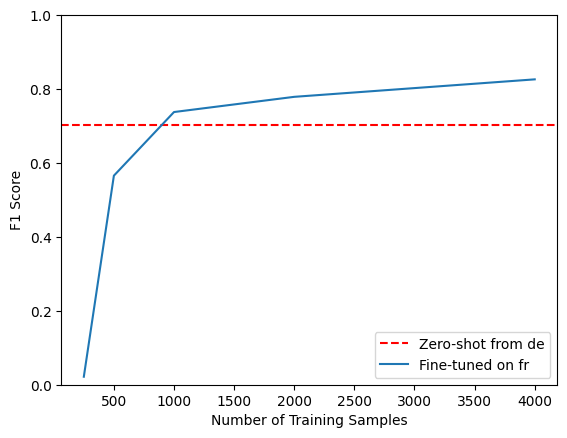

In [53]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.axhline(f1_scores["de"]["fr"], ls="--", color="r")
metrics_df.set_index("num_samples").plot(ax=ax)
plt.legend(["Zero-shot from de", "Fine-tuned on fr"], loc="lower right")
plt.ylim((0, 1))
plt.xlabel("Number of Training Samples")
plt.ylabel("F1 Score")
plt.show()


# Fine-tune on multi-lingual data

In [54]:
from datasets import concatenate_datasets

def concatenate_splits(corpora):
    multi_corpus = DatasetDict()

    for split in corpora[0].keys():
        multi_corpus[split] = concatenate_datasets([corpus[split] for corpus in corpora])
    return multi_corpus

panx_de_fr_multi = concatenate_splits([panx_de_encoded, panx_fr_encoded])

In [55]:
training_args.logging_steps = len(panx_de_fr_multi["train"]) // batch_size
training_args.push_to_hub = False
trainer = Trainer(
    model_init=model_init,
    args=training_args,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    train_dataset=panx_de_fr_multi["train"],
    eval_dataset=panx_de_fr_multi["validation"],
    tokenizer=xlmr_tokenizer
)
trainer.train()
trainer.push_to_hub(commit_message="Training completed!")


  0%|          | 0/2145 [00:00<?, ?it/s]

{'loss': 0.3035, 'grad_norm': 5.544822692871094, 'learning_rate': 1.6666666666666667e-05, 'epoch': 1.0}


  0%|          | 0/358 [00:00<?, ?it/s]

{'eval_loss': 0.18670733273029327, 'eval_f1': 0.8214481739497572, 'eval_runtime': 6.6782, 'eval_samples_per_second': 1284.77, 'eval_steps_per_second': 53.607, 'epoch': 1.0}
{'loss': 0.1558, 'grad_norm': 3.6228957176208496, 'learning_rate': 8.333333333333334e-06, 'epoch': 2.0}


  0%|          | 0/358 [00:00<?, ?it/s]

{'eval_loss': 0.1653294414281845, 'eval_f1': 0.8477103301384452, 'eval_runtime': 6.8826, 'eval_samples_per_second': 1246.618, 'eval_steps_per_second': 52.015, 'epoch': 2.0}
{'loss': 0.1139, 'grad_norm': 9.472610473632812, 'learning_rate': 0.0, 'epoch': 3.0}


  0%|          | 0/358 [00:00<?, ?it/s]

{'eval_loss': 0.16650311648845673, 'eval_f1': 0.8531188834992766, 'eval_runtime': 6.6484, 'eval_samples_per_second': 1290.536, 'eval_steps_per_second': 53.848, 'epoch': 3.0}
{'train_runtime': 258.2857, 'train_samples_per_second': 199.314, 'train_steps_per_second': 8.305, 'train_loss': 0.19106356391817816, 'epoch': 3.0}


training_args.bin:   0%|          | 0.00/5.24k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/hieundx/xlm-roberta-base-finetuned-panx-de/commit/682aac585e97852f97e8d11764aaa4de717aa918', commit_message='Training completed!', commit_description='', oid='682aac585e97852f97e8d11764aaa4de717aa918', pr_url=None, repo_url=RepoUrl('https://huggingface.co/hieundx/xlm-roberta-base-finetuned-panx-de', endpoint='https://huggingface.co', repo_type='model', repo_id='hieundx/xlm-roberta-base-finetuned-panx-de'), pr_revision=None, pr_num=None)

In [56]:
for lang in langs:
    f1 = evaluate_lang_performance(lang, trainer)
    print(f"{lang}: {f1:.3f}")

  0%|          | 0/263 [00:00<?, ?it/s]

de: 0.862


  0%|          | 0/96 [00:00<?, ?it/s]

fr: 0.849


  0%|          | 0/35 [00:00<?, ?it/s]

it: 0.806


  0%|          | 0/25 [00:00<?, ?it/s]

en: 0.676


In [57]:
corpora = [panx_de_encoded]

for lang in langs[1:]:
    training_args.output_dir = f'models/xlm-roberta-base-finetuned-panx-{lang}'

    ds_encoded = encode_panx_dataset(panx_ch[lang])
    metrics = train_on_subset(ds_encoded, ds_encoded['train'].num_rows)
    f1_scores[lang][lang] = metrics['f1_score'][0]

    corpora.append(ds_encoded)

  0%|          | 0/573 [00:00<?, ?it/s]

{'loss': 0.6335, 'grad_norm': 11.512612342834473, 'learning_rate': 1.6710296684118673e-05, 'epoch': 0.99}


  0%|          | 0/96 [00:00<?, ?it/s]

{'eval_loss': 0.3379150927066803, 'eval_f1': 0.7969450439980077, 'eval_runtime': 7.5128, 'eval_samples_per_second': 304.811, 'eval_steps_per_second': 12.778, 'epoch': 1.0}
{'loss': 0.286, 'grad_norm': 20.65700912475586, 'learning_rate': 8.420593368237348e-06, 'epoch': 1.99}


  0%|          | 0/96 [00:00<?, ?it/s]

{'eval_loss': 0.2902672588825226, 'eval_f1': 0.8259488379869587, 'eval_runtime': 15.3099, 'eval_samples_per_second': 149.577, 'eval_steps_per_second': 6.27, 'epoch': 2.0}
{'loss': 0.2174, 'grad_norm': 27.71369743347168, 'learning_rate': 1.3089005235602095e-07, 'epoch': 2.98}


  0%|          | 0/96 [00:00<?, ?it/s]

{'eval_loss': 0.28559598326683044, 'eval_f1': 0.8386444107233182, 'eval_runtime': 15.5662, 'eval_samples_per_second': 147.114, 'eval_steps_per_second': 6.167, 'epoch': 3.0}
{'train_runtime': 358.9594, 'train_samples_per_second': 38.277, 'train_steps_per_second': 1.596, 'train_loss': 0.3779020286563387, 'epoch': 3.0}


  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

{'loss': 0.8923, 'grad_norm': 13.972517013549805, 'learning_rate': 1.6666666666666667e-05, 'epoch': 1.0}


  0%|          | 0/35 [00:00<?, ?it/s]

{'eval_loss': 0.4025495946407318, 'eval_f1': 0.7021943573667712, 'eval_runtime': 4.5347, 'eval_samples_per_second': 185.24, 'eval_steps_per_second': 7.718, 'epoch': 1.0}
{'loss': 0.3536, 'grad_norm': 10.500673294067383, 'learning_rate': 8.333333333333334e-06, 'epoch': 2.0}


  0%|          | 0/35 [00:00<?, ?it/s]

{'eval_loss': 0.28190693259239197, 'eval_f1': 0.7736228387615601, 'eval_runtime': 5.8458, 'eval_samples_per_second': 143.692, 'eval_steps_per_second': 5.987, 'epoch': 2.0}
{'loss': 0.2427, 'grad_norm': 6.649882793426514, 'learning_rate': 0.0, 'epoch': 3.0}


  0%|          | 0/35 [00:00<?, ?it/s]

{'eval_loss': 0.27967506647109985, 'eval_f1': 0.8022782750203419, 'eval_runtime': 8.0989, 'eval_samples_per_second': 103.717, 'eval_steps_per_second': 4.322, 'epoch': 3.0}
{'train_runtime': 132.5666, 'train_samples_per_second': 38.019, 'train_steps_per_second': 1.584, 'train_loss': 0.49617227826799665, 'epoch': 3.0}


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

{'loss': 1.2168, 'grad_norm': 3.981015682220459, 'learning_rate': 1.6833333333333334e-05, 'epoch': 0.98}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.7614645957946777, 'eval_f1': 0.47282051282051285, 'eval_runtime': 2.9714, 'eval_samples_per_second': 198.561, 'eval_steps_per_second': 8.414, 'epoch': 1.0}
{'loss': 0.6516, 'grad_norm': 8.585225105285645, 'learning_rate': 8.666666666666668e-06, 'epoch': 1.96}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.48420196771621704, 'eval_f1': 0.6102981029810298, 'eval_runtime': 1.9184, 'eval_samples_per_second': 307.543, 'eval_steps_per_second': 13.031, 'epoch': 2.0}
{'loss': 0.4827, 'grad_norm': 14.782960891723633, 'learning_rate': 5.000000000000001e-07, 'epoch': 2.94}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.440826416015625, 'eval_f1': 0.6454095656954371, 'eval_runtime': 1.127, 'eval_samples_per_second': 523.527, 'eval_steps_per_second': 22.183, 'epoch': 3.0}
{'train_runtime': 85.6098, 'train_samples_per_second': 41.35, 'train_steps_per_second': 1.752, 'train_loss': 0.7785156472524007, 'epoch': 3.0}


  0%|          | 0/25 [00:00<?, ?it/s]

In [58]:
corpora_encoded = concatenate_splits(corpora)

training_args.logging_steps = len(corpora_encoded["train"]) // batch_size
training_args.output_dir = "models/xlm-roberta-base-finetuned-panx-all"

trainer = Trainer(
    model_init=model_init,
    args=training_args,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    train_dataset=corpora_encoded["train"],
    eval_dataset=corpora_encoded["validation"],
    tokenizer=xlmr_tokenizer
)

trainer.train()
trainer.push_to_hub(commit_message="Training completed!")

  0%|          | 0/2505 [00:00<?, ?it/s]

{'loss': 0.3079, 'grad_norm': 5.250273704528809, 'learning_rate': 1.6676646706586826e-05, 'epoch': 1.0}


  0%|          | 0/418 [00:00<?, ?it/s]

{'eval_loss': 0.19817222654819489, 'eval_f1': 0.8152310059764521, 'eval_runtime': 8.7141, 'eval_samples_per_second': 1148.718, 'eval_steps_per_second': 47.968, 'epoch': 1.0}
{'loss': 0.1644, 'grad_norm': 4.099465847015381, 'learning_rate': 8.353293413173653e-06, 'epoch': 2.0}


  0%|          | 0/418 [00:00<?, ?it/s]

{'eval_loss': 0.18026161193847656, 'eval_f1': 0.8429526342269821, 'eval_runtime': 8.5456, 'eval_samples_per_second': 1171.359, 'eval_steps_per_second': 48.914, 'epoch': 2.0}
{'loss': 0.122, 'grad_norm': 3.2692086696624756, 'learning_rate': 2.994011976047904e-08, 'epoch': 3.0}


  0%|          | 0/418 [00:00<?, ?it/s]

{'eval_loss': 0.17914289236068726, 'eval_f1': 0.8496023138105567, 'eval_runtime': 8.0251, 'eval_samples_per_second': 1247.336, 'eval_steps_per_second': 52.087, 'epoch': 3.0}
{'train_runtime': 312.6326, 'train_samples_per_second': 192.111, 'train_steps_per_second': 8.013, 'train_loss': 0.19797799572973193, 'epoch': 3.0}


sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.30k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/hieundx/xlm-roberta-base-finetuned-panx-all/commit/34d242c4897d2560a7d13f6768b292733e5fc96c', commit_message='Training completed!', commit_description='', oid='34d242c4897d2560a7d13f6768b292733e5fc96c', pr_url=None, repo_url=RepoUrl('https://huggingface.co/hieundx/xlm-roberta-base-finetuned-panx-all', endpoint='https://huggingface.co', repo_type='model', repo_id='hieundx/xlm-roberta-base-finetuned-panx-all'), pr_revision=None, pr_num=None)

In [59]:
for idx, lang in enumerate(langs):
    f1_scores['all'][lang] = get_f1_score(trainer, corpora[idx]['test'])

scores_data = {
    'de': f1_scores['de'],
    'each': {
        lang: f1_scores[lang][lang] for lang in langs
    },
    'all': f1_scores['all']
}

f1_scores_df = pd.DataFrame(scores_data).T.round(4)
f1_scores_df.rename_axis(index='Fine-tuned on', columns='Evaluated on', inplace=True)

f1_scores_df

  0%|          | 0/263 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Evaluated on,de,fr,it,en
Fine-tuned on,,,,
de,0.8586,0.7017,0.6827,0.6033
each,0.8586,0.8414,0.7763,0.6439
all,0.8591,0.8540,0.8625,0.7679
